In [42]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import os.path as op
import seaborn as sns
from math import pow
from sklearn.preprocessing import OneHotEncoder

In [43]:
#videos = pd.read_parquet(op.join("df_metadata_sample_clean.parquet.gzip"), engine="fastparquet")
videos = pd.read_parquet(op.join(os.getcwd(), "Dataset", "df_metadata_sample_clean.parquet.gzip"), engine="pyarrow")
#videos = pd.read_csv('df_metadata_sample_Pace.csv')

videos

,index,categories,channel_id,dislike_count,display_id,duration,like_count,upload_date,view_count,subs_before_video,tags_count,num_comms,description,title,virality,title_positive,title_negative,title_length,description_length
0,676973,Gaming,UCrnftLporTV1YgYbVi7GFsw,31,TqLn2hX6zoA,655,314,2019-03-13,45868.0,30595.541667,15,39.0,Send me your submissions to be featured https:...,Twitch Stream Fails and Epic Moments Compilati...,1.039202,0,1,52,296
1,66343748,Sports,UC2EuJ9xTs0XkDZI9YGx7QZA,51,MCEQL6g5EIU,614,468,2017-03-25,29088.0,20086.343750,15,179.0,If Floyd Mayweather vs. Conor McGregor ends up...,Conor McGregor's Best Asset: Undermining Doubt...,1.037371,1,3,63,599
2,12315685,Entertainment,UCiJfiEg1FImWsVuEu0L8X6Q,1,l3_IlJr-8_U,30,44,2016-08-18,11506.0,126756.750000,8,0.0,Watch Srirastu Subhamastu telugu movie dailogu...,Srirastu Subhamastu Latest Teaser | Allu Siris...,0.795803,0,0,93,439
3,29036231,People & Blogs,UCVptfwYcLxRED8w4Efy0CsA,88,y126khD2Q5k,373,1788,2016-04-05,189885.0,2942.500000,41,125.0,COACHING & TRAINING PLANS\nVisit harryruns.com...,Interval Training: How To Become a Faster Runner,1.521678,1,0,48,1044
4,56543085,Film & Animation,UCAP57cF-FSjJKzzXg7ntPlQ,0,JCuwthnCRpg,120,380,2019-01-08,7559.0,130292.885417,1,23.0,Now in theatres!,STALKER - Janus Films Trailer,0.758276,0,0,29,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1257064,39977981,Gaming,UCN-Klifn9C7kINwpIA0uOHw,2,QhWTZppzqxI,1579,302,2019-02-11,7518.0,305116.869792,13,49.0,🎤 Check out these links! 🎤\nhttp://patreon.com...,[7] Ace Combat 7: Skies Unknown w/ GaLm,0.706752,0,1,39,428
1257065,71798200,Gaming,UCskB-HpWs7BAVPvjdJf9-6g,1,1DytQ27ZFCQ,743,15,2015-12-29,116.0,6585.125000,8,19.0,Hey friends it's me KaOs Broly I hope you enjo...,Splatoon - New Piranha Pit Map Gameplay,0.541604,0,0,39,699
1257066,35917598,Music,UCQEloCMWEZFep85nHfbbg8Q,0,wiP1xD1Tapc,389,0,2014-01-24,175.0,95064.375000,2,0.0,For more videos click | http://goo.gl/6NU4DG\n...,Haryanvi Krishan Bhajan Sri Radhe Govinda Jug ...,0.451085,0,0,95,356
1257067,54370862,People & Blogs,UCBu0KdNokE4MqdkacvH37_A,1,3qmjq0j3-zE,143,1,2019-01-18,55.0,25481.217593,1,0.0,A new ice cream shop in North Texas is turning...,New ice cream shop turning dessert into a fine...,0.396753,1,0,50,74


## Define virality

In [44]:
#log scale to adapt to the distributions
#Theoretical try :
#videos['virality']=np.log(videos['view_count']+1)/np.log(videos['subs_before_video']+1)

#Empirical ajustment : it looks like -log(.), so by taking exp(-.) we obtain a line.
#Note that now virality is generally in [0,1]
videos['virality']=1-np.exp(-np.log(videos['view_count']+1)/np.log(videos['subs_before_video']+1))

#Now we add an affine function to get a straight line : we want a max* virality of 1 for 10 subs and same for 10M subs
#*max of "visible cloud of points"
sparsity=2.1 #Becomes harder to approach 1 for high sparsity
videos['virality']=(0.055*np.log10(videos['subs_before_video'])-0.05+videos['virality'])**sparsity

(0.0, 2.0)

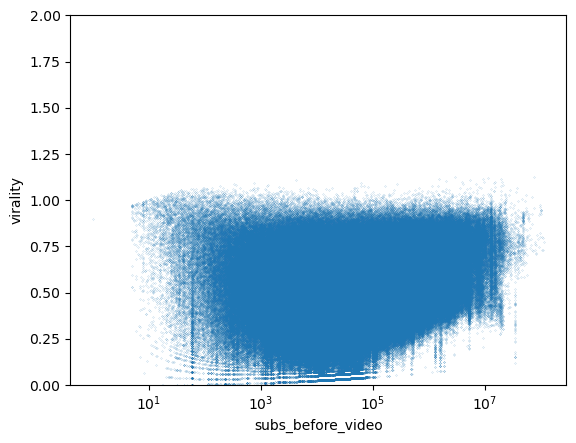

In [45]:
videos.plot.scatter(x='subs_before_video', y='virality',logx=True,s=0.01)
plt.ylim([0,2])

### Is our definition good ? Generally tends to decreases with number of subscribers

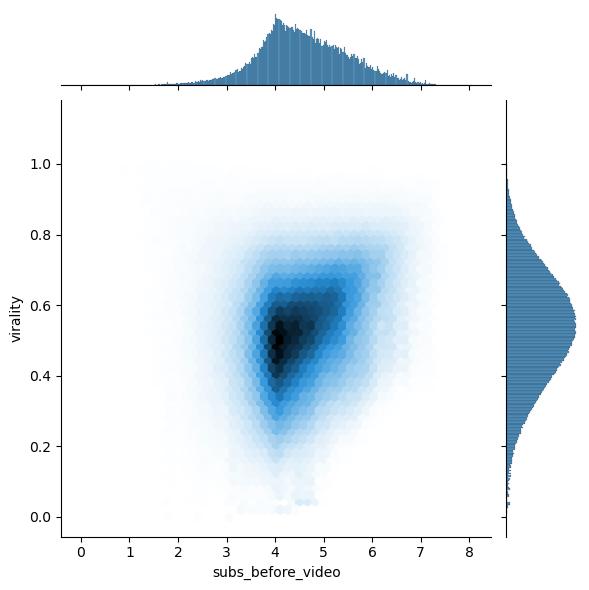

In [46]:
sns.jointplot(x=np.log10(videos['subs_before_video']), y=videos['virality'], kind="hex")


 ### Check normal distribution to use Linear Gaussian Model

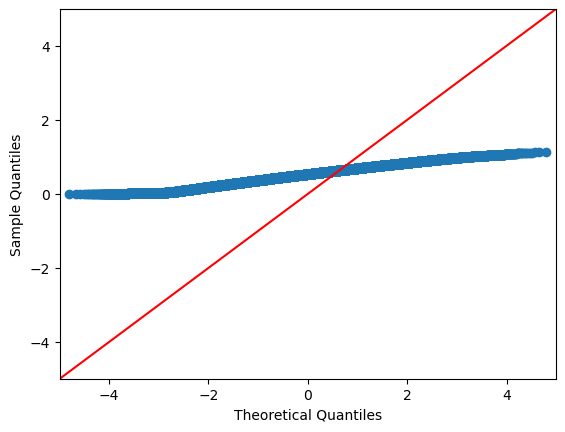

In [47]:
#select_group=videos[(videos['subs_before_video']>10**3) & (videos['subs_before_video']<10**5)]
#virality=select_group['virality']
virality=videos['virality']
#virality.hist(bins=100) Already in heat plot
#test normal distrib
import statsmodels.api as sm
import pylab

sm.qqplot(virality, line='45')
pylab.show()

### Underdispersion diagnostic : we can divide the output in different groups of viralities to transform it into count data, and use Negative Binomial regression model.

## Appreciation

In [48]:
#Like/dislike ratio
videos['like_ratio']=np.log(videos['like_count']+2)/np.log(videos['dislike_count']+2)

In [49]:
videos

,index,categories,channel_id,dislike_count,display_id,duration,like_count,upload_date,view_count,subs_before_video,tags_count,num_comms,description,title,virality,title_positive,title_negative,title_length,description_length,like_ratio
0,676973,Gaming,UCrnftLporTV1YgYbVi7GFsw,31,TqLn2hX6zoA,655,314,2019-03-13,45868.0,30595.541667,15,39.0,Send me your submissions to be featured https:...,Twitch Stream Fails and Epic Moments Compilati...,0.698570,0,1,52,296,1.646140
1,66343748,Sports,UC2EuJ9xTs0XkDZI9YGx7QZA,51,MCEQL6g5EIU,614,468,2017-03-25,29088.0,20086.343750,15,179.0,If Floyd Mayweather vs. Conor McGregor ends up...,Conor McGregor's Best Asset: Undermining Doubt...,0.680080,1,3,63,599,1.549693
2,12315685,Entertainment,UCiJfiEg1FImWsVuEu0L8X6Q,1,l3_IlJr-8_U,30,44,2016-08-18,11506.0,126756.750000,8,0.0,Watch Srirastu Subhamastu telugu movie dailogu...,Srirastu Subhamastu Latest Teaser | Allu Siris...,0.592583,0,0,93,439,3.484980
3,29036231,People & Blogs,UCVptfwYcLxRED8w4Efy0CsA,88,y126khD2Q5k,373,1788,2016-04-05,189885.0,2942.500000,41,125.0,COACHING & TRAINING PLANS\nVisit harryruns.com...,Interval Training: How To Become a Faster Runner,0.844042,1,0,48,1044,1.664508
4,56543085,Film & Animation,UCAP57cF-FSjJKzzXg7ntPlQ,0,JCuwthnCRpg,120,380,2019-01-08,7559.0,130292.885417,1,23.0,Now in theatres!,STALKER - Janus Films Trailer,0.566394,0,0,29,16,8.577429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1257064,39977981,Gaming,UCN-Klifn9C7kINwpIA0uOHw,2,QhWTZppzqxI,1579,302,2019-02-11,7518.0,305116.869792,13,49.0,🎤 Check out these links! 🎤\nhttp://patreon.com...,[7] Ace Combat 7: Skies Unknown w/ GaLm,0.559486,0,1,39,428,4.123964
1257065,71798200,Gaming,UCskB-HpWs7BAVPvjdJf9-6g,1,1DytQ27ZFCQ,743,15,2015-12-29,116.0,6585.125000,8,19.0,Hey friends it's me KaOs Broly I hope you enjo...,Splatoon - New Piranha Pit Map Gameplay,0.316501,0,0,39,699,2.578902
1257066,35917598,Music,UCQEloCMWEZFep85nHfbbg8Q,0,wiP1xD1Tapc,389,0,2014-01-24,175.0,95064.375000,2,0.0,For more videos click | http://goo.gl/6NU4DG\n...,Haryanvi Krishan Bhajan Sri Radhe Govinda Jug ...,0.326523,0,0,95,356,1.000000
1257067,54370862,People & Blogs,UCBu0KdNokE4MqdkacvH37_A,1,3qmjq0j3-zE,143,1,2019-01-18,55.0,25481.217593,1,0.0,A new ice cream shop in North Texas is turning...,New ice cream shop turning dessert into a fine...,0.253122,1,0,50,74,1.000000


### Preprocess categories to fit Random Forest

In [50]:
onehot=OneHotEncoder()
encoded=onehot.fit_transform(videos[['categories']])
videos[onehot.categories_[0]]=encoded.toarray()
onehot.categories_[0]

array(['Autos & Vehicles', 'Comedy', 'Education', 'Entertainment',
       'Film & Animation', 'Gaming', 'Howto & Style', 'Music',
       'News & Politics', 'Nonprofits & Activism', 'People & Blogs',
       'Pets & Animals', 'Science & Technology', 'Sports',
       'Travel & Events', 'Unknown'], dtype=object)

In [51]:
videos

,index,categories,channel_id,dislike_count,display_id,duration,like_count,upload_date,view_count,subs_before_video,...,Howto & Style,Music,News & Politics,Nonprofits & Activism,People & Blogs,Pets & Animals,Science & Technology,Sports,Travel & Events,Unknown
0,676973,Gaming,UCrnftLporTV1YgYbVi7GFsw,31,TqLn2hX6zoA,655,314,2019-03-13,45868.0,30595.541667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,66343748,Sports,UC2EuJ9xTs0XkDZI9YGx7QZA,51,MCEQL6g5EIU,614,468,2017-03-25,29088.0,20086.343750,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,12315685,Entertainment,UCiJfiEg1FImWsVuEu0L8X6Q,1,l3_IlJr-8_U,30,44,2016-08-18,11506.0,126756.750000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,29036231,People & Blogs,UCVptfwYcLxRED8w4Efy0CsA,88,y126khD2Q5k,373,1788,2016-04-05,189885.0,2942.500000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,56543085,Film & Animation,UCAP57cF-FSjJKzzXg7ntPlQ,0,JCuwthnCRpg,120,380,2019-01-08,7559.0,130292.885417,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1257064,39977981,Gaming,UCN-Klifn9C7kINwpIA0uOHw,2,QhWTZppzqxI,1579,302,2019-02-11,7518.0,305116.869792,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1257065,71798200,Gaming,UCskB-HpWs7BAVPvjdJf9-6g,1,1DytQ27ZFCQ,743,15,2015-12-29,116.0,6585.125000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1257066,35917598,Music,UCQEloCMWEZFep85nHfbbg8Q,0,wiP1xD1Tapc,389,0,2014-01-24,175.0,95064.375000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1257067,54370862,People & Blogs,UCBu0KdNokE4MqdkacvH37_A,1,3qmjq0j3-zE,143,1,2019-01-18,55.0,25481.217593,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [52]:
## Delete columns to save memory

In [53]:
videos.dtypes

index                             int64
categories                     category
channel_id                       object
dislike_count                     int32
display_id                       object
duration                          int64
like_count                        int32
upload_date              datetime64[ns]
view_count                      float64
subs_before_video               float64
tags_count                        int64
num_comms                       float64
description                      object
title                            object
virality                        float64
title_positive                    int64
title_negative                    int64
title_length                      int64
description_length                int64
like_ratio                      float64
Autos & Vehicles                float64
Comedy                          float64
Education                       float64
Entertainment                   float64
Film & Animation                float64


In [54]:
videos.drop(['categories', 'channel_id','dislike_count','display_id','like_count','upload_date','description','title'], axis=1, inplace=True)

In [55]:
videos.dtypes

index                      int64
duration                   int64
view_count               float64
subs_before_video        float64
tags_count                 int64
num_comms                float64
virality                 float64
title_positive             int64
title_negative             int64
title_length               int64
description_length         int64
like_ratio               float64
Autos & Vehicles         float64
Comedy                   float64
Education                float64
Entertainment            float64
Film & Animation         float64
Gaming                   float64
Howto & Style            float64
Music                    float64
News & Politics          float64
Nonprofits & Activism    float64
People & Blogs           float64
Pets & Animals           float64
Science & Technology     float64
Sports                   float64
Travel & Events          float64
Unknown                  float64
dtype: object

# Models and sampling

In [56]:
"""
# Take a sample for testing
videos_sample = videos.sample(1000, replace = False)
x_sample=videos_sample[['duration','subs_before_video','like_ratio','tags_count','Autos & Vehicles', 'Comedy', 'Education', 'Entertainment',
       'Film & Animation', 'Gaming', 'Howto & Style', 'Music',
       'News & Politics', 'Nonprofits & Activism', 'People & Blogs',
       'Pets & Animals', 'Science & Technology', 'Sports',
       'Travel & Events', 'Unknown']]
# We include subs before video because maybe a video is still more easily viral for big channels according to our definition
y_sample=videos_sample['virality']

# Categorize the variable
y_sample = [y_sample >= np.quantile(y_sample,0.95)][0]

# Split in train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_sample, y_sample, test_size = 0.3)
"""

"\n# Take a sample for testing\nvideos_sample = videos.sample(1000, replace = False)\nx_sample=videos_sample[['duration','subs_before_video','like_ratio','tags_count','Autos & Vehicles', 'Comedy', 'Education', 'Entertainment',\n       'Film & Animation', 'Gaming', 'Howto & Style', 'Music',\n       'News & Politics', 'Nonprofits & Activism', 'People & Blogs',\n       'Pets & Animals', 'Science & Technology', 'Sports',\n       'Travel & Events', 'Unknown']]\n# We include subs before video because maybe a video is still more easily viral for big channels according to our definition\ny_sample=videos_sample['virality']\n\n# Categorize the variable\ny_sample = [y_sample >= np.quantile(y_sample,0.95)][0]\n\n# Split in train and test\nfrom sklearn.model_selection import train_test_split\nX_train, X_test, y_train, y_test = train_test_split(x_sample, y_sample, test_size = 0.3)\n"

In [57]:
x=videos[['duration','subs_before_video','tags_count','title_positive', 'title_negative','title_length', 'description_length',
          'Autos & Vehicles', 'Comedy', 'Education', 'Entertainment',
          'Film & Animation', 'Gaming', 'Howto & Style', 'Music',
          'News & Politics', 'Nonprofits & Activism', 'People & Blogs',
          'Pets & Animals', 'Science & Technology', 'Sports',
          'Travel & Events', 'Unknown']]
# We include subs before video because maybe a video is still more easily viral for big channels according to our definition
y=videos['virality']

In [58]:
y

0          0.698570
1          0.680080
2          0.592583
3          0.844042
4          0.566394
             ...   
1257064    0.559486
1257065    0.316501
1257066    0.326523
1257067    0.253122
1257068    0.484335
Name: virality, Length: 1257069, dtype: float64

In [59]:
# Split in train and test
from sklearn.model_selection import train_test_split

# Categorize the variable
quantile_val = np.quantile(y,0.95)
y = y.apply(lambda x : 1 if x > quantile_val else 0)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)

In [60]:
# Useful to judge model strength
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, average_precision_score, auc

# define function to get all important performance metrics
def performance(y_test, y_pred, y_score) :
    
    # Calculate performance scores
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_score)
    average_precision = average_precision_score(y_test, y_score)

    # Print performance
    print('Performance :')
    print('  - Accuracy score = {:.2f}'.format(accuracy))
    print('  - F1 score = {:.2f}'.format(f1))
    print('  - Precision score = {:.2f}'.format(precision))
    print('  - Recall score = {:.2f}'.format(recall))
    print('  - ROC AUC score = {:.2f}'.format(roc_auc))
    print('  - Average precision score = {:.2f}'.format(average_precision))

## Random forest

In [20]:
%%time
# Fit Random Forest Regression to the dataset
# import the regressor
from sklearn.ensemble import RandomForestClassifier
 
 # create regressor object
regressor = RandomForestClassifier(n_estimators = 100, max_depth = 30, random_state = 0)
 
# fit the regressor with x and y data
regressor.fit(X_train, y_train) 

# Predicting values
y_pred = regressor.predict(X_test)
y_score = regressor.predict_proba(X_test)[:, 1]

# Calculate performance on Europe test
performance(y_test, y_pred, y_score)

Performance :
  - Accuracy score = 0.95
  - F1 score = 0.00
  - Precision score = 0.90
  - Recall score = 0.00
  - ROC AUC score = 0.77
  - Average precision score = 0.23
CPU times: total: 1min 19s
Wall time: 1min 19s


In [41]:
# Choose parameter values to test for cross-validation
param_grid = {"n_estimators":[50, 100, 150], 
              "max_depth":[10, 20, 30]}

# Choose the estimator
estimator = RandomForestClassifier(random_state = 0)

# Cross-validation with GridSearchCV
clf = GridSearchCV(estimator, param_grid, scoring='precision', cv=StratifiedKFold(n_splits=3, shuffle=True))

# Fit data into the model
clf.fit(X_train, y_train)

# Predicting values
y_pred = clf.predict(X_test)

# Proba for the greater label
y_score = clf.predict_proba(X_test)[:, 1]

# Best parameters
best_param = clf.best_estimator_.get_params()
parameters = {'C':best_param['C'], 'penalty':best_param['penalty']}
print('Best parameters for Logistic regression:')
print('C:', parameters['C'])
print('Penalty:', parameters['penalty'])
print('------------')

# Calculate performance on Europe test
performance(y_test, y_pred, y_score)

KeyError: 'C'

In [21]:
pd.Series(y_pred).value_counts()

0    377072
1        49
dtype: int64

In [22]:
pd.Series(y_test[y_pred == 1]).value_counts()

1    44
0     5
Name: virality, dtype: int64

## Logistic regression

In [23]:
# Import classifie
from sklearn.linear_model import LogisticRegression

# Useful for cross-validation 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

In [39]:
%%time
# Choose parameter values to test for cross-validation
param_grid = {"C":np.logspace(-3,3,4), 
              "penalty":["l2"]}

# Choose the estimator
estimator = LogisticRegression(max_iter=200)

# Cross-validation with GridSearchCV
clf = GridSearchCV(estimator, param_grid, scoring='precision', cv=StratifiedKFold(n_splits=3, shuffle=True))

# Fit data into the model
clf.fit(X_train, y_train)

# Predicting values
y_pred = clf.predict(X_test)

# Proba for the greater label
y_score = clf.predict_proba(X_test)[:, 1]

# Best parameters
best_param = clf.best_estimator_.get_params()
parameters = {'C':best_param['C'], 'penalty':best_param['penalty']}
print('Best parameters for Logistic regression:')
print('C:', parameters['C'])
print('Penalty:', parameters['penalty'])
print('------------')

# Calculate performance on Europe test
performance(y_test, y_pred, y_score)

# Look at coefs
coefs = clf.best_estimator_.coef_


Best parameters for Logistic regression:
C: 0.001
Penalty: l2
------------
Performance :
  - Accuracy score = 0.95
  - F1 score = 0.03
  - Precision score = 0.40
  - Recall score = 0.01
  - ROC AUC score = 0.53
  - Average precision score = 0.07
CPU times: total: 47.6 s
Wall time: 47.6 s


In [25]:
pd.Series(y_pred).value_counts()

0    376411
1       710
dtype: int64

In [26]:
pd.Series(y_test[y_pred == 1]).value_counts()

0    426
1    284
Name: virality, dtype: int64

## XGBoost

In [27]:
%%time
import xgboost as xgb

# In this cell, a large number of error messages were generated, which we again got rid of using a small trick to make this 
# cell easier to read. These error messages could however reappear if this cell is rerun.

# Choose the estimator
estimator = xgb.XGBClassifier(objective="binary:logistic", random_state=42, booster = "gblinear", 
                              max_depth = 30, learning_rate = 0.1, n_estimators = 20)

# Fit data into the model
estimator.fit(X_train, y_train)

# Predicting values
y_pred = estimator.predict(X_test)

# Proba for the greater label
y_score = estimator.predict_proba(X_test)[:, 1]

# Calculate performance on Europe test
performance(y_test, y_pred, y_score)

# Look at coefs
coefs = estimator.coef_
coefs

[13:56:53] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_depth" } are not used.

Performance :
  - Accuracy score = 0.95
  - F1 score = 0.01
  - Precision score = 0.40
  - Recall score = 0.01
  - ROC AUC score = 0.61
  - Average precision score = 0.09
CPU times: total: 18.2 s
Wall time: 3.39 s


array([-1.32375e-04,  1.30418e-07, -1.07678e-02, -1.26901e-01,
       -5.98972e-02, -1.08119e-02, -6.24201e-05, -1.07294e+00,
       -3.65031e-01, -9.94160e-01, -6.49377e-01, -4.07650e-01,
       -8.99859e-01, -7.64432e-01, -7.67402e-01, -1.91148e+00,
       -1.71614e+00, -8.24760e-01, -9.70655e-01, -1.03348e+00,
       -1.33766e+00, -1.16028e+00, -2.24087e+00])

In [28]:
pd.Series(y_pred).value_counts()

0    376857
1       264
dtype: int64

In [29]:
pd.Series(y_test[y_pred == 1]).value_counts()

0    158
1    106
Name: virality, dtype: int64

In [30]:
%%time
import xgboost as xgb

# In this cell, a large number of error messages were generated, which we again got rid of using a small trick to make this 
# cell easier to read. These error messages could however reappear if this cell is rerun.

# Choose the estimator
estimator = xgb.XGBClassifier(objective="binary:logistic", random_state=42, booster = "gbtree", 
                             max_depth = 30, learning_rate = 0.1, n_estimators = 20)

# Fit data into the model
estimator.fit(X_train, y_train)

# Predicting values
y_pred = estimator.predict(X_test)

# Proba for the greater label
y_score = estimator.predict_proba(X_test)[:, 1]

# Calculate performance on Europe test
performance(y_test, y_pred, y_score)

Performance :
  - Accuracy score = 0.95
  - F1 score = 0.15
  - Precision score = 0.57
  - Recall score = 0.09
  - ROC AUC score = 0.77
  - Average precision score = 0.24
CPU times: total: 5min 29s
Wall time: 22.7 s


In [31]:
pd.Series(y_pred).value_counts()

0    374235
1      2886
dtype: int64

In [32]:
pd.Series(y_test[y_pred == 1]).value_counts()

1    1654
0    1232
Name: virality, dtype: int64

In [ ]:
# 13 --> 65 

In [74]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 13)

In [75]:
%%time
import xgboost as xgb

# Useful for cross-validation 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

# In this cell, a large number of error messages were generated, which we again got rid of using a small trick to make this 
# cell easier to read. These error messages could however reappear if this cell is rerun.

# Choose parameter values to test for cross-validation
param_grid = {'max_depth': [10],
              'n_estimators': [100],
              'learning_rate': [0.05],
              'booster': ['gbtree']}

# Choose the estimator
estimator = xgb.XGBClassifier(objective="binary:logistic", random_state=42)

# Cross-validation with GridSearchCV
clf = GridSearchCV(estimator, param_grid, scoring='precision', cv=StratifiedKFold(n_splits=3, shuffle=True))

# Fit data into the model
clf.fit(X_train, y_train)

# Predicting values
y_pred = clf.predict(X_test)

# Proba for the greater label
y_score = clf.predict_proba(X_test)[:, 1]

# Best parameters
best_param = clf.best_estimator_.get_params()
parameters = {'max_depth':best_param['max_depth'], 'n_estimators':best_param['n_estimators'], 'learning_rate':best_param['learning_rate'], 'booster':best_param['booster']}
print('Best parameters for XGBoost:')
print('max_depth:', parameters['max_depth'])
print('n_estimators:', parameters['n_estimators'])
print('learning_rate:', parameters['learning_rate'])
print('booster:', parameters['booster'])
print('------------')

# Calculate performance on Europe test
performance(y_test, y_pred, y_score)

# Look at coefs
if (parameters['booster']=='gblinear'):
    coefs = clf.best_estimator_.coef_
    print(coefs)

Best parameters for XGBoost:
max_depth: 10
n_estimators: 100
learning_rate: 0.05
booster: gbtree
------------
Performance :
  - Accuracy score = 0.95
  - F1 score = 0.09
  - Precision score = 0.65
  - Recall score = 0.05
  - ROC AUC score = 0.79
  - Average precision score = 0.25
CPU times: total: 26min 59s
Wall time: 1min 43s


In [79]:
from sklearn.metrics import confusion_matrix
confusion_matrix_xgb = confusion_matrix(y_test, y_pred)

In [84]:
# Inspired by tutorial 7
def plot_confusion_matrix(confusion_matrix):
    [[TN, FP],[FN, TP]] = confusion_matrix
    label = np.asarray([['TP {}'.format(TP), 'FP {}'.format(FP)],
                        ['FN {}'.format(FN), 'TN {}'.format(TN)]])
    
    df_cm = pd.DataFrame(confusion_matrix, index=['Yes', 'No'], columns=['Positive', 'Negative']) 
    
    return sns.heatmap(df_cm, cmap='YlOrRd', annot=label, annot_kws={"size": 16}, cbar=False, fmt='')

Text(0.5, 1.0, 'Confusion matrix for the best model')

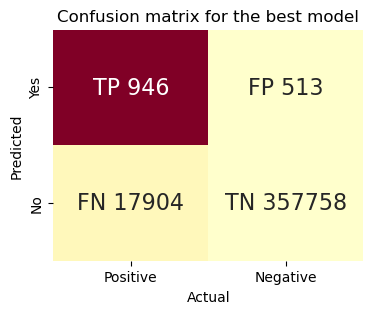

In [85]:
plt.figure(figsize = (4,3)) 
ax = plot_confusion_matrix(confusion_matrix_xgb)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion matrix for the best model')

In [35]:
print(pd.Series(y_pred).value_counts())
print(pd.Series(y_test[y_pred == 1]).value_counts())

0    374686
1      2435
dtype: int64
1    1505
0     930
Name: virality, dtype: int64


In [34]:
%%time
import xgboost as xgb

# Useful for cross-validation 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

# In this cell, a large number of error messages were generated, which we again got rid of using a small trick to make this 
# cell easier to read. These error messages could however reappear if this cell is rerun.

# Choose parameter values to test for cross-validation
param_grid = {'max_depth': [20],
              'n_estimators': [50,100,150],
              'learning_rate': [0.1, 0.05],
              'booster': ['gbtree', 'gblinear']}

# Choose the estimator
estimator = xgb.XGBClassifier(objective="binary:logistic", random_state=42)

# Cross-validation with GridSearchCV
clf = GridSearchCV(estimator, param_grid, scoring='precision', cv=StratifiedKFold(n_splits=3, shuffle=True))

# Fit data into the model
clf.fit(X_train, y_train)

# Predicting values
y_pred = clf.predict(X_test)

# Proba for the greater label
y_score = clf.predict_proba(X_test)[:, 1]

# Best parameters
best_param = clf.best_estimator_.get_params()
parameters = {'max_depth':best_param['max_depth'], 'n_estimators':best_param['n_estimators'], 'learning_rate':best_param['learning_rate'], 'booster':best_param['booster']}
print('Best parameters for XGBoost:')
print('max_depth:', parameters['max_depth'])
print('n_estimators:', parameters['n_estimators'])
print('learning_rate:', parameters['learning_rate'])
print('booster:', parameters['booster'])
print('------------')

# Calculate performance on Europe test
performance(y_test, y_pred, y_score)

# Look at coefs
if (parameters['booster']=='gblinear'):
    coefs = clf.best_estimator_.coef_
    print(coefs)

[14:24:09] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_depth" } are not used.

[14:24:10] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_depth" } are not used.

[14:24:12] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_depth" } are not used.

[14:24:13] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_depth" } are not used.

[14:24:16] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_depth" } are not used.

[14:2

In [36]:
print(pd.Series(y_pred).value_counts())
print(pd.Series(y_test[y_pred == 1]).value_counts())

0    374686
1      2435
dtype: int64
1    1505
0     930
Name: virality, dtype: int64


In [37]:
%%time
import xgboost as xgb

# Useful for cross-validation 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

# In this cell, a large number of error messages were generated, which we again got rid of using a small trick to make this 
# cell easier to read. These error messages could however reappear if this cell is rerun.

# Choose parameter values to test for cross-validation
param_grid = {'max_depth': [30],
              'n_estimators': [100, 150],
              'learning_rate': [0.1, 0.05],
              'booster': ['gbtree', 'gblinear']}

# Choose the estimator
estimator = xgb.XGBClassifier(objective="binary:logistic", random_state=42)

# Cross-validation with GridSearchCV
clf = GridSearchCV(estimator, param_grid, scoring='precision', cv=StratifiedKFold(n_splits=3, shuffle=True))

# Fit data into the model
clf.fit(X_train, y_train)

# Predicting values
y_pred = clf.predict(X_test)

# Proba for the greater label
y_score = clf.predict_proba(X_test)[:, 1]

# Best parameters
best_param = clf.best_estimator_.get_params()
parameters = {'max_depth':best_param['max_depth'], 'n_estimators':best_param['n_estimators'], 'learning_rate':best_param['learning_rate'], 'booster':best_param['booster']}
print('Best parameters for XGBoost:')
print('max_depth:', parameters['max_depth'])
print('n_estimators:', parameters['n_estimators'])
print('learning_rate:', parameters['learning_rate'])
print('booster:', parameters['booster'])
print('------------')

# Calculate performance on Europe test
performance(y_test, y_pred, y_score)

# Look at coefs
if (parameters['booster']=='gblinear'):
    coefs = clf.best_estimator_.coef_
    print(coefs)

[14:55:07] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_depth" } are not used.

[14:55:10] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_depth" } are not used.

[14:55:12] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_depth" } are not used.

[14:55:15] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_depth" } are not used.

[14:55:19] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_depth" } are not used.

[14:5

In [38]:
print(pd.Series(y_pred).value_counts())
print(pd.Series(y_test[y_pred == 1]).value_counts())

0    374494
1      2627
dtype: int64
1    1606
0    1021
Name: virality, dtype: int64


## KNN

In [5]:
"""
%%time

from sklearn.neighbors import KNeighborsClassifier

# In this cell, a large number of error messages were generated, which we again got rid of using a small trick to make this 
# cell easier to read. These error messages could however reappear if this cell is rerun.

# Choose parameter values to test for cross-validation
k_range = [2, 4, 6]
param_grid = dict(n_neighbors=k_range)

# Choose the estimator
estimator = KNeighborsClassifier()

# Cross-validation with GridSearchCV
clf = GridSearchCV(estimator, param_grid, scoring='f1', cv=StratifiedKFold(n_splits=3, shuffle=True))

# Fit data into the model
clf.fit(X_train, y_train)

# Predicting values
y_pred = clf.predict(X_test)

# Proba for the greater label
y_score = clf.predict_proba(X_test)[:, 1]

# Best parameters
best_param = clf.best_estimator_.get_params()
parameters = {'k':best_param['n_neighbors']}
print('Best parameters for K-Nearest Neighbor:')
print('k:', parameters['k'])
print('------------')

# Calculate performance on Europe test
performance(y_test, y_pred, y_score)
"""

NameError: name 'X_train' is not defined

## SVM

In [ ]:
"""
%%time

from sklearn.svm import SVC

# Choose parameter values to test for cross-validation
param_grid = {'C': [0.1], 
              'gamma': [0.1],
              'kernel': ['linear']} 

# Choose the estimator
estimator = SVC(C = 0.1, gamma = 0.1, kernel = "linear", probability=True)

# Fit data into the model
estimator.fit(X_train, y_train)

# Predicting values
y_pred = estimator.predict(X_test)

# Proba for the greater label
y_score = estimator.predict_proba(X_test)[:, 1]

# Calculate performance on Europe test
performance(y_test, y_pred, y_score)

# Look at coefs
coefs = estimator.coef_
coefs
"""